In [1]:
import pandas as pd
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Flatten, Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# Define the path to the directory containing the feature files
directory_path = '/content/drive/MyDrive/FYP_dataset/features'

# Get a list of all feature file paths in the directory
feature_files = glob.glob(directory_path + '/*.csv')

print(len(feature_files))

Mounted at /content/drive
1802


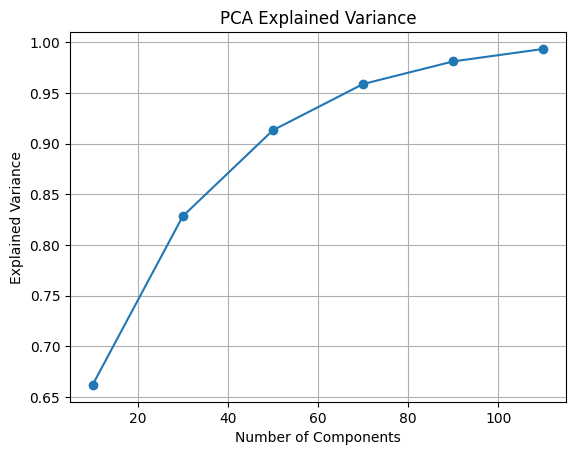

Optimal Number of Components: 110


In [3]:
# Define lists to store the feature and target data
X = []
y_v = []

# Iterate over each feature file
for file in feature_files:
    # Read the feature file into a DataFrame
    df = pd.read_csv(file)

    # Extract the features and target variables
    features = df.drop(['Arousal_Value', 'Valence_Value', 'frameTime'], axis=1).values
    valence = df['Valence_Value'].values

    # Append the data to the lists
    X.append(features)
    y_v.append(valence)

# Concatenate the feature and target arrays
X = np.concatenate(X)
y_v = np.concatenate(y_v)

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the input data for LSTM
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Define the learning rate
learning_rate = 0.001

# Apply PCA with different numbers of components
num_components = range(10, 111, 20)

explained_variances = []

for n in num_components:
    # Apply PCA to reduce the dimensionality of the feature space
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)

    # Build the BiLSTM model for Arousal
    model_v = Sequential()
    model_v.add(Bidirectional(CuDNNLSTM(64, return_sequences=True), input_shape=(X_pca.shape[1], 1)))
    model_v.add(Flatten())
    model_v.add(Dense(1))
    model_v.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))

    # Train the Arousal model
    model_v.fit(X_pca, y_v, epochs=25, batch_size=32, verbose=0)

    explained_variances.append(sum(pca.explained_variance_ratio_))

# Plot explained variances vs. number of components
plt.plot(num_components, explained_variances, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

# Select the optimal number of components
optimal_components = num_components[np.argmax(explained_variances)]
print(f'Optimal Number of Components: {optimal_components}')